In [26]:
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
import tensorflow as tf
from matplotlib import pyplot as plt
import torch.nn as nn
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict
import torch.optim as optim
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import preprocessing

import datetime
from sklearn import linear_model

In [27]:
EV_Stations = pd.DataFrame(pd.read_csv('EV_stations.csv'))
EV_Stations.head()

,Country,State,ZIP,Latitude,Longitude,EV Level1 EVSE Num,EV Level2 EVSE Num,EV DC Fast Count,ID,Open Date,Access Code,Facility Type,EV On-Site Renewable Source
0,US,AK,99801,58.354895,-134.495377,NaN,2.0,NaN,72524,2/1/15,public,UTILITY,NaN
1,US,AK,99801,58.298366,-134.404006,NaN,2.0,NaN,81601,2/1/17,public,PARKING_GARAGE,NaN
2,US,AK,99801,58.363727,-134.575550,NaN,1.0,NaN,85589,8/1/15,public,OFFICE_BLDG,HYDRO
3,US,AK,99518,61.169369,-149.911144,NaN,2.0,NaN,88609,11/30/17,public,NaN,NaN
4,US,AK,99669,60.494658,-151.045242,NaN,3.0,NaN,112694,11/27/17,public,RESTAURANT,NaN


In [28]:
EV_Stations = EV_Stations[EV_Stations['State']=='WA']
EV_Stations.head()

,Country,State,ZIP,Latitude,Longitude,EV Level1 EVSE Num,EV Level2 EVSE Num,EV DC Fast Count,ID,Open Date,Access Code,Facility Type,EV On-Site Renewable Source
51405,US,WA,98503,47.044011,-122.822404,NaN,4.0,NaN,33351,1/15/18,public,MUNI_GOV,NaN
51406,US,WA,98188,47.443377,-122.296229,36.0,NaN,NaN,33717,3/1/10,public,AIRPORT,NaN
51407,US,WA,98502,47.035421,-122.938962,2.0,NaN,NaN,35337,8/15/09,public,GROCERY,NaN
51408,US,WA,99252,47.673347,-117.388933,1.0,2.0,NaN,35620,4/15/10,public,OFFICE_BLDG,NaN
51409,US,WA,99201,47.654998,-117.425025,NaN,4.0,NaN,35621,4/15/10,public,RESTAURANT,NaN


In [29]:
features = ['ZIP', 'Latitude', 'Longitude', 'ID','Open Date']
EV_Stations = EV_Stations[features]
EV_Stations.head()

,ZIP,Latitude,Longitude,ID,Open Date
51405,98503,47.044011,-122.822404,33351,1/15/18
51406,98188,47.443377,-122.296229,33717,3/1/10
51407,98502,47.035421,-122.938962,35337,8/15/09
51408,99252,47.673347,-117.388933,35620,4/15/10
51409,99201,47.654998,-117.425025,35621,4/15/10


In [30]:
EV_Stations.drop_duplicates(subset = "ID",keep = False, inplace= True) ##dropping duplicate vins
EV_Stations.head()

,ZIP,Latitude,Longitude,ID,Open Date
51405,98503,47.044011,-122.822404,33351,1/15/18
51406,98188,47.443377,-122.296229,33717,3/1/10
51407,98502,47.035421,-122.938962,35337,8/15/09
51408,99252,47.673347,-117.388933,35620,4/15/10
51409,99201,47.654998,-117.425025,35621,4/15/10


In [31]:
HHMM = EV_Stations['Open Date'].values
years = []
y = EV_Stations['Open Date']

for i in range(len(HHMM)):
    years.append(HHMM[i][5:8])
    
years = str(years).replace('/', '')
#years

In [32]:
#for i in range(len(years)):
#    if(years[i]!="'" and years[i]!=","):
#        y[i]=years[i:i+1]

In [37]:
df = EV_Stations
X = df['ID'].values

In [38]:
zipped = list(zip(X, y))
df = pd.DataFrame(zipped, columns=['Year', 'Total Sold'])
df.head()
X=X.reshape()

,Year,Total Sold
0,33351,1/15/18
1,33717,3/1/10
2,35337,8/15/09
3,35620,4/15/10
4,35621,4/15/10


,ID,Open Date
51405,33351,1/15/18
51406,33717,3/1/10
51407,35337,8/15/09
51408,35620,4/15/10
51409,35621,4/15/10


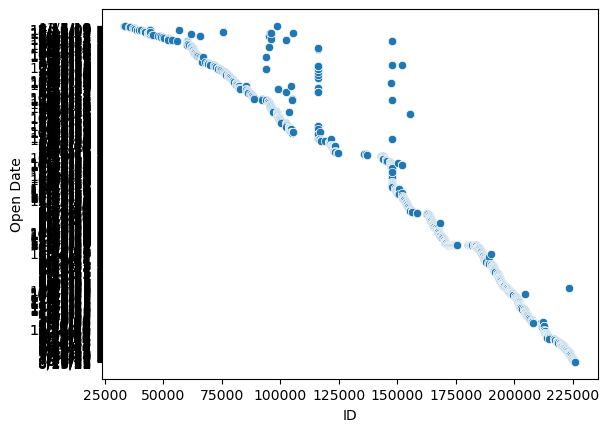

In [35]:
features = ['ID','Open Date']
EV_Stations_Test=EV_Stations[features]
sns.scatterplot(EV_Stations_Test,x="ID", y= "Open Date")
EV_Stations_Test.head()